In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from pprint import pprint

ModuleNotFoundError: No module named 'seaborn'

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import xgboost

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
def conv(df):
  df['date']=pd.to_datetime(df['date']).dt.date
  #df.set_index('date',inplace=True)
  return df

In [ ]:
cols=['totcases','totdeaths','logtot','logdet'] #Dropping columns that'll not be used in model building

In [ ]:
#Filling null values for hospitalized and ICU
def fillnull(df_on):
  p1=df_on.isnull().sum()['TotalICU']
  p2=df_on.isnull().sum()['logdiff']+1
  c1=np.corrcoef(df_on['logdiff'][p1:],df_on['TotalHospitalized'][p1:])
  c2=np.corrcoef(df_on['logdiff'][p1:],df_on['TotalICU'][p1:])
  for j in range(1,p1):
    i=p1-j
    df_on.loc[i,'TotalHospitalized']=df_on.loc[i+1,'TotalHospitalized']-(0.54*df_on['TotalHospitalized'][p1:].std()*(df_on.loc[i+1,'logdiff']-df_on.loc[i,'logdiff'])/(df_on['logdiff'][p2:].std()))
    df_on.loc[i,'TotalICU']=df_on.loc[i+1,'TotalICU']-(0.76*df_on['TotalICU'][p1:].std()*(df_on.loc[i+1,'logdiff']-df_on.loc[i,'logdiff'])/(df_on['logdiff'][p2:].std()))
  return df_on

In [ ]:
#Checking for null values
def checknull(df):
  N=df.isnull().sum()
  print('Log difference of deaths:',N['logddiff_det'])
  print('TotalHospitalized',N['TotalHospitalized'])
  print('TotalICU',N['TotalICU'])

In [ ]:
#Function to create correlation heatmaps
def corr_heatmap(df):
  plt.subplots(figsize=(12,12))
  pos=df.isnull().sum()['logdiff']
  sb.heatmap(df.drop(columns=cols)[pos:].corr(),annot=True)

In [ ]:
#Function to find death/case before and after vaccination
def compare(df1,df2):
  a=(df1.loc[305,'totdeaths']-df1.loc[0,'totdeaths'])/(df1.loc[305,'totcases']-df1.loc[0,'totcases'])
  b=(df2.loc[110,'totdeaths']-df2.loc[0,'totdeaths'])/(df2.loc[110,'totcases']-df2.loc[0,'totcases'])
  print('Death/Case before vaccination ',a)
  print('Death/Case after vaccination',b)
  print('Percentage reduction in Death/Case:',((a-b)*100/a))
  p=df2.isnull().sum()['TotalVaccinated']
  daily=[]
  for i in range(1,len(df2['totcases'])):
    daily.append(df2.loc[i,'totcases']-df2.loc[i-1,'totcases'])
  f,ax=plt.subplots(2,1,figsize=(10,5))
  ax[0].plot(daily)
  ax[1].plot(df2['DailyVaccinated'])
  ax[0].set_title('Daily new cases')
  ax[1].set_title('Daily vaccinations')
  print(np.corrcoef(df2['DailyVaccinated'][p:],daily[p-1:]))

In [ ]:
#Function to create scatter plots
def scatter(df_onv):
  f,ax=plt.subplots(6,3,figsize=(25,25))
  ax=ax.flatten()
  for i,c in enumerate(df_onv.columns[7:]):
    ax[i].scatter(df_onv[c],df_onv['logdiff'])
    ax[i].set_title(c)

In [ ]:
#Function to visualize log diff of cases and log diff of deaths
def logd(df):
  f,ax=plt.subplots(2,1,figsize=(20,10))
  ax[0].plot(df['logdiff'])
  ax[0].set_title('Log difference of daily cases')
  ax[1].plot(df['logddiff_det'])
  ax[1].set_title('Log difference of daily deaths')

In [ ]:
#Function to convert logdifferneces to quantities
def logconv(first,li):
  count=[]
  count.append(int(np.exp(li[0]+first)))
  for d in range(1,len(li)):
    count.append(int(np.exp(li[d]+np.log(count[d-1]))))
  return count

In [ ]:
#Linear regression function
def linreg(x,y,x1,y1):
  reg = LinearRegression().fit(x,y)
  print('MAE:',mean_absolute_error(y1,reg.predict(x1)))
  print('MSE:',mean_squared_error(y1,reg.predict(x1)))
  print('Rscore:',reg.score(x1,y1))
  return reg.predict(x1)

In [ ]:
def RandomForestSearchCV2(x1,y1,x1_test, y1_test,vaccination):
  model = RandomForestRegressor(n_estimators = 10,random_state=42)
  model.fit(xtrain,ytrain)

  predicted_cases = model.predict(xtest)
  MAE = mean_absolute_error(ytest , predicted_cases)
  print('MAE:', MAE)
  print('MSE',mean_squared_error(ytest,predicted_cases))
  print('Rscore',model.score(xtest,ytest))
  pc2=model.predict(vaccination)
  return predicted_cases,pc2

In [ ]:
def RandomForestSearchCV1(x1,y1,x1_test, y1_test):
  model = RandomForestRegressor(random_state=42)
  model.fit(xtrain,ytrain)

  predicted_cases = model.predict(xtest)
  MAE = mean_absolute_error(ytest , predicted_cases)
  print('MAE:', MAE)
  print('MSE',mean_squared_error(ytest,predicted_cases))
  print('Rscore',model.score(xtest,ytest))
  return predicted_cases

In [ ]:
def RandomForestSearchCV(x1,y1,x1_test, y1_test,vaccination):
  from sklearn.model_selection import RandomizedSearchCV
  n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
  max_features = ['auto', 'sqrt']
  max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
  max_depth.append(None)
  min_samples_split = [2, 5, 10]
  min_samples_leaf = [1, 2, 4]
  bootstrap = [True, False]
  
  # Create the random grid
  random_grid = {'n_estimators': n_estimators,
                'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'bootstrap': bootstrap}
  # pprint(random_grid)
  {'bootstrap': [True, False],
  'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
  'max_features': ['auto', 'sqrt'],
  'min_samples_leaf': [1, 2, 4],
  'min_samples_split': [2, 5, 10],
  'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

  # Use the random grid to search for best hyperparameters
  # First create the base model to tune
  rf = RandomForestRegressor(random_state=42)
 
  rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 15, cv = 3, verbose=2, random_state=42, n_jobs = -1)
  rf_random.fit(x1, y1)

  def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
   
    print('Model Performance')
    print(model)
    print('MAE:',mean_absolute_error(test_labels,model.predict(test_features)))
    print('MSE:',mean_squared_error(test_labels,model.predict(test_features)))

    return model.predict(test_features)
    
  base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
  base_model.fit(x1, y1)
  best_random = rf_random.best_estimator_
  prediction2 = evaluate(best_random, x1_test, y1_test)
  return prediction2,best_random.predict(vaccination)



In [ ]:
def hcorr(df,limit):
  cols=['totcases','totdeaths','logtot','date','logdet','logddiff_det']
  c=[]
  for i,val in enumerate(df.drop(columns=cols).corr()['logdiff']):
    if abs(val) > limit:
      c.append(df.drop(columns=cols).corr()['logdiff'].index[i])
  return df[c]

In [ ]:
def clean(df):
  for c in df.drop(columns='date').columns:
    for i in range(len(df)):
      if df.loc[i,c]==float('-inf') or df.loc[i,c]==float('inf') or df.loc[i,c]=='#NAME?':
        df.loc[i,c]=0
  return df

**ONTARIO**


In [ ]:
df1=clean(fillnull(conv(pd.read_csv('../data_Final/ontario_data1.csv'))))
df2=conv(pd.read_csv('../data_Final/ontario_vacc1.csv'))

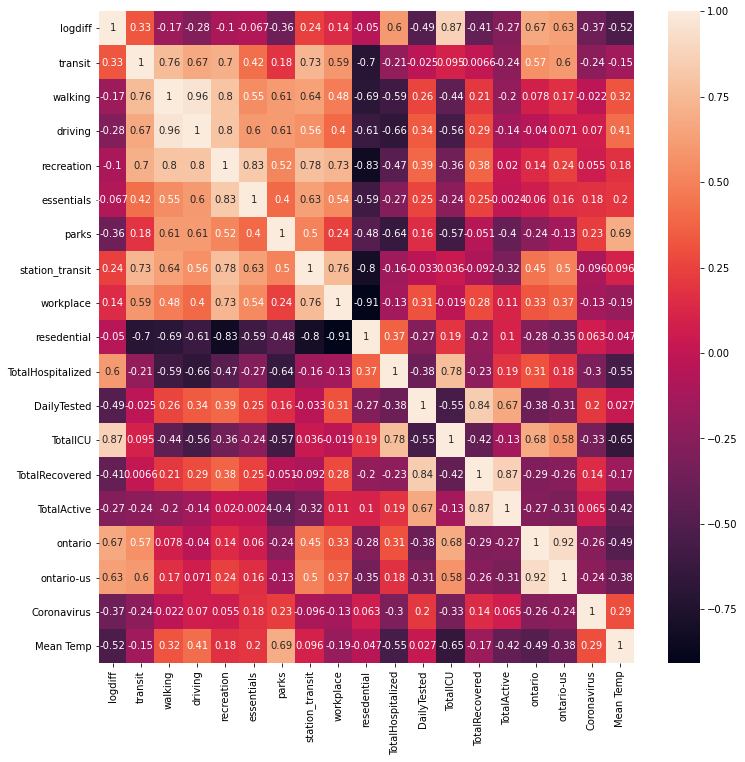

In [ ]:
corr_heatmap(df1.drop(columns='logddiff_det'))
#corr_heatmap(df2.drop(columns='logddiff_det'))

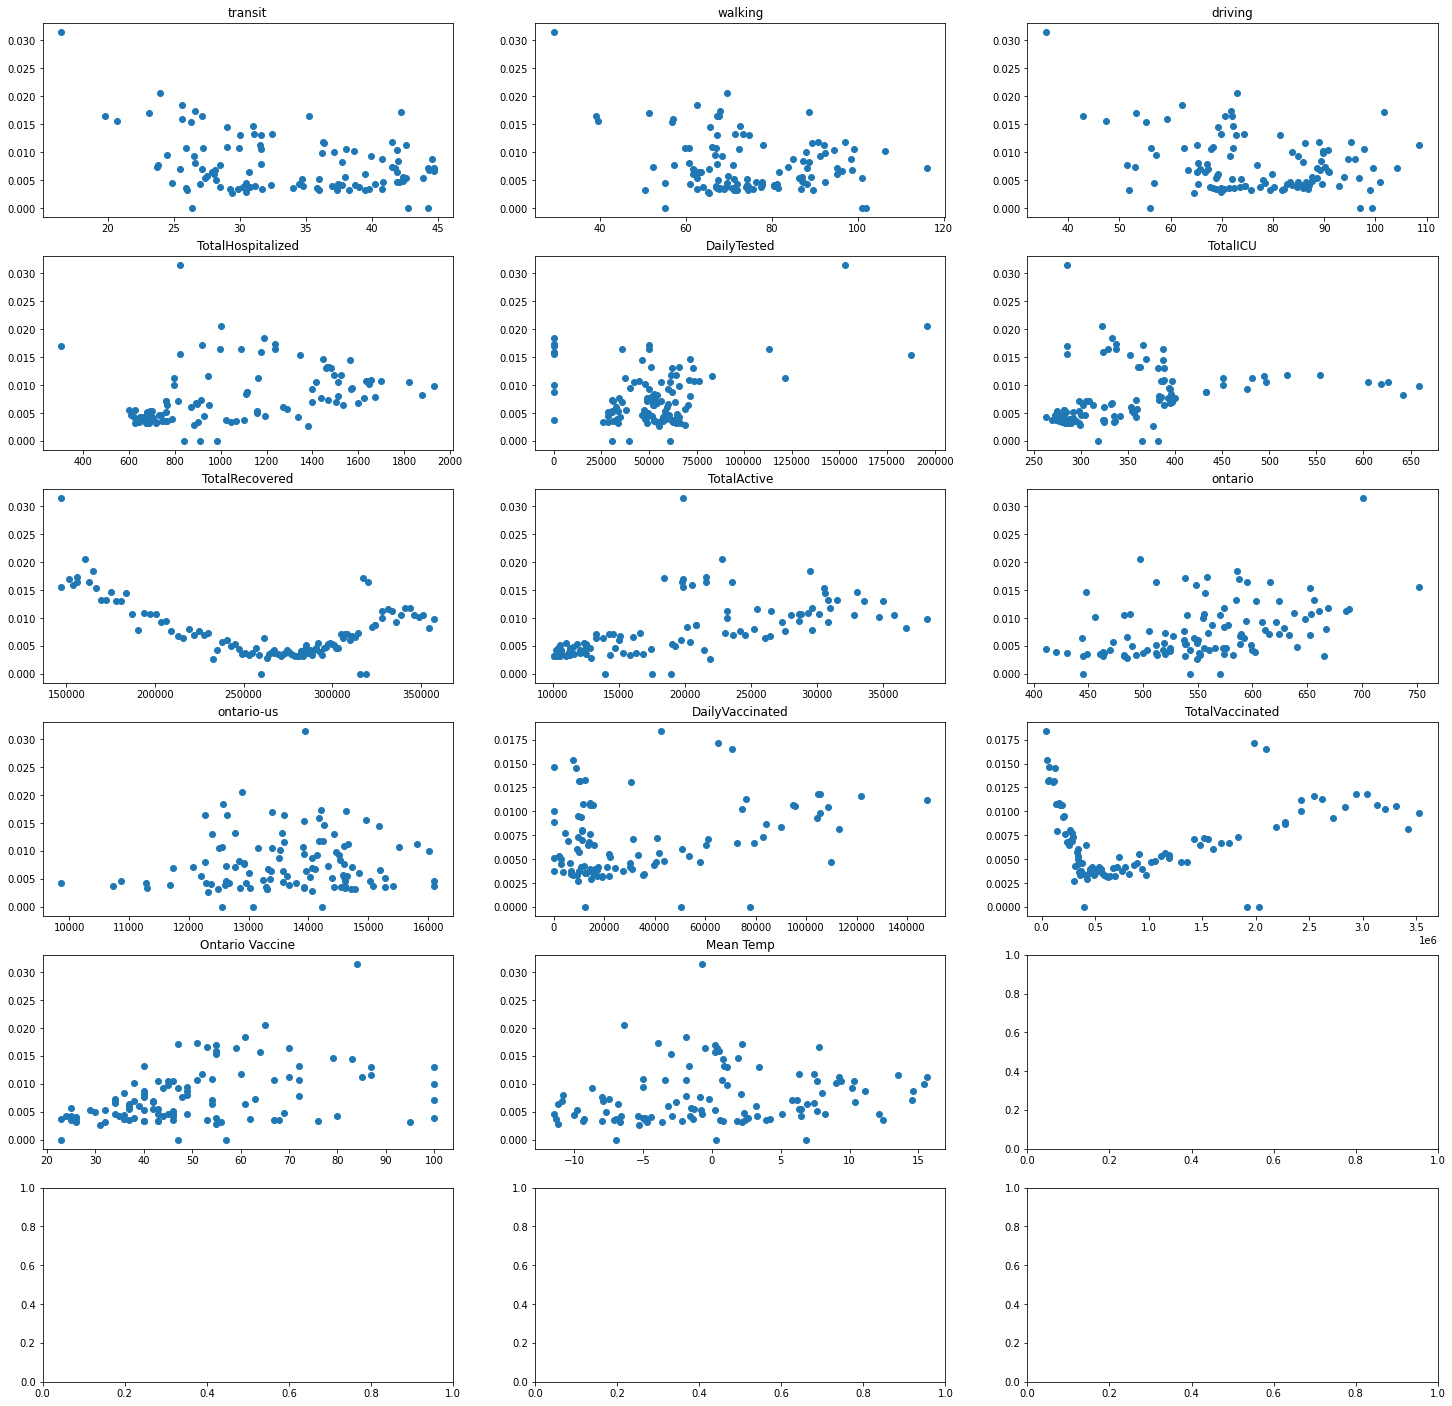

In [ ]:
#scatter(df1)
scatter(df2)

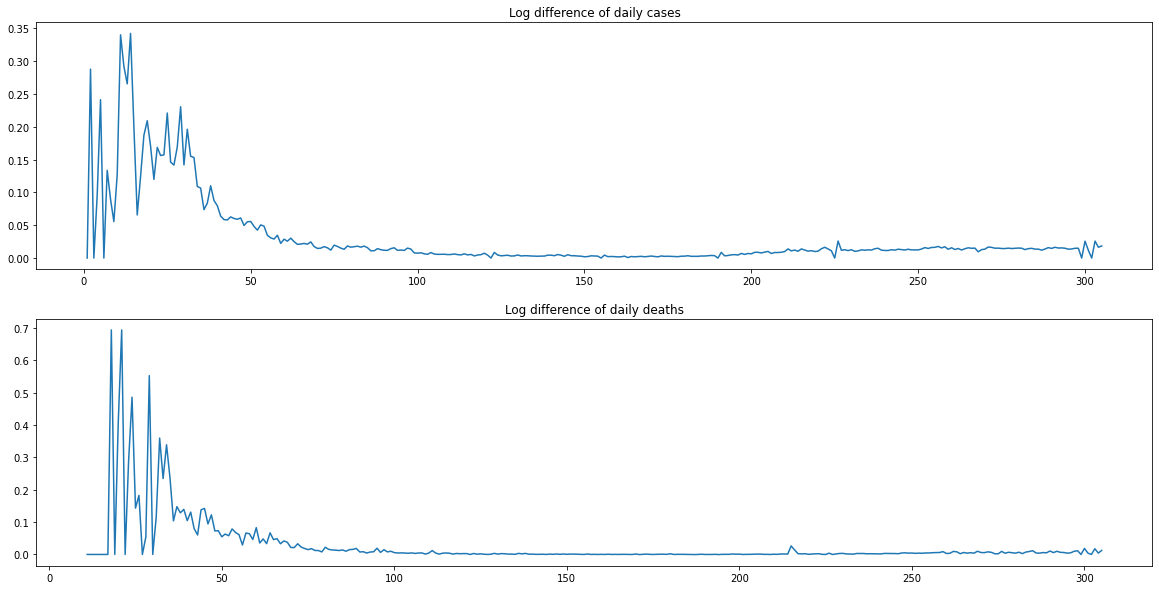

In [ ]:
logd(df1)
#logd(df2)

In [ ]:
#Modifying features from scatter plots
a=[];b=[];c=[]
d=['DailyTested','TotalActive','TotalRecovered','Coronavirus']
for i in d:
  for j in range(len(df1)):
    if i=='DailyTested':
      if df1.loc[j,i]==0:
        df1.loc[j,i]=0
      else:
        df1.loc[j,i]=(np.log(df1.loc[j,i]))
    else:
      if df1.loc[j,i]==0:
        df1.loc[j,i]=1/0.1
      else:
        df1.loc[j,i]=1/df1.loc[j,i]

In [ ]:
x=hcorr(df1,0.4)

In [ ]:
x.corr()

,logdiff,TotalHospitalized,DailyTested,TotalICU,TotalRecovered,ontario,ontario-us,Coronavirus,Mean Temp
logdiff,1.000000,0.604444,-0.657005,0.872677,0.784778,0.674394,0.633815,0.508295,-0.522370
TotalHospitalized,0.604444,1.000000,-0.389333,0.775533,0.443226,0.310099,0.178599,0.371196,-0.551234
DailyTested,-0.657005,-0.389333,1.000000,-0.665653,-0.809611,-0.736207,-0.664314,-0.517348,0.378174
TotalICU,0.872677,0.775533,-0.665653,1.000000,0.763994,0.679744,0.576348,0.448522,-0.653506
TotalRecovered,0.784778,0.443226,-0.809611,0.763994,1.000000,0.920976,0.870217,0.553698,-0.488078
ontario,0.674394,0.310099,-0.736207,0.679744,0.920976,1.000000,0.924225,0.372338,-0.489074
ontario-us,0.633815,0.178599,-0.664314,0.576348,0.870217,0.924225,1.000000,0.333058,-0.386913
Coronavirus,0.508295,0.371196,-0.517348,0.448522,0.553698,0.372338,0.333058,1.000000,-0.344799
Mean Temp,-0.522370,-0.551234,0.378174,-0.653506,-0.488078,-0.489074,-0.386913,-0.344799,1.000000


In [ ]:
#Test train data for ontario
xtrain=x[['TotalRecovered','Coronavirus']][1:245];ytrain=df1['logdiff'][1:245]
xtest=x[['TotalRecovered','Coronavirus',]][245:];ytest=df1['logdiff'][245:]

In [ ]:
lin=linreg(xtrain,ytrain,xtest,ytest)

MAE: 0.003680728636316352
MSE: 2.347388421111153e-05
Rscore: -0.7432947845209783


In [ ]:
B=df1[['TotalRecovered','Coronavirus']][195:306]

In [ ]:
#randomized search model
predicted_cases,without_vacc=RandomForestSearchCV(xtrain,ytrain,xtest,ytest,B)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   40.8s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   50.2s finished


Model Performance
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)
MAE: 0.003885157488274561
MSE: 2.2342727560064374e-05


In [ ]:
#base model
predicted_cases1,without_vacc1=RandomForestSearchCV2(xtrain,ytrain,xtest,ytest,B)

MAE: 0.002490701224836064
MSE 1.6026484381947406e-05
Rscore -0.1902114871994964


Text(0.5, 1.0, 'Cumulative covid cases')

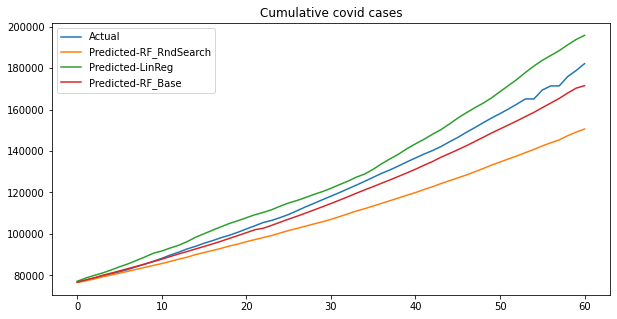

In [ ]:
A_on=logconv(df1['logtot'][244],predicted_cases)
Alin=logconv(df1['logtot'][244],lin)
A_RF=logconv(df1['logtot'][244],predicted_cases1)
B=[]
for i in range(len(df1['totcases'][245:])):
  B.append(df1.loc[245+i,'totcases'])
plt.subplots(figsize=(10,5))
plt.plot(B)
plt.plot(A_on)
plt.plot(Alin)
plt.plot(A_RF)
plt.legend(['Actual','Predicted-RF_RndSearch','Predicted-LinReg','Predicted-RF_Base'])
plt.title('Cumulative covid cases')

In [ ]:
d=['TotalVaccinated','Ontario Vaccine']
for i in d:
  for j in range(len(df2)):
      if df2.loc[j,i]==0:
        df2.loc[j,i]=0
      else:
        df2.loc[j,i]=(np.log(df2.loc[j,i]))

In [ ]:
x=hcorr(df2,0.39)

In [ ]:
x.corr()

,logdiff,TotalRecovered,TotalActive,ontario,Ontario Vaccine
logdiff,1.000000,-0.462786,0.585265,0.419067,0.436974
TotalRecovered,-0.462786,1.000000,-0.258081,-0.129826,-0.233774
TotalActive,0.585265,-0.258081,1.000000,0.362599,0.282865
ontario,0.419067,-0.129826,0.362599,1.000000,0.315756
Ontario Vaccine,0.436974,-0.233774,0.282865,0.315756,1.000000


In [ ]:
#Test train data for ontario vaccine
xtrain=x.drop(columns='logdiff')[9:90];ytrain=df2['logdiff'][9:90]
xtest=x.drop(columns='logdiff')[90:];ytest=df2['logdiff'][90:]

In [ ]:
lin=linreg(xtrain,ytrain,xtest,ytest)

MAE: 0.0030923440678320337
MSE: 1.919978518960884e-05
Rscore: -0.25011954306596706


In [ ]:
#base model
pred_cases=RandomForestSearchCV1(xtrain,ytrain,xtest,ytest)


MAE: 0.003914621600651795
MSE 2.17930667384124e-05
Rscore -0.4189710126431512


In [ ]:
#dummyB
B=np.zeros((4,4))

In [ ]:
#randomized search model
pred_cases1,flag=RandomForestSearchCV(xtrain,ytrain,xtest,ytest,B)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   46.9s finished


Model Performance
RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=50, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=2000, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)
MAE: 0.004078395444535839
MSE: 2.288925992414512e-05


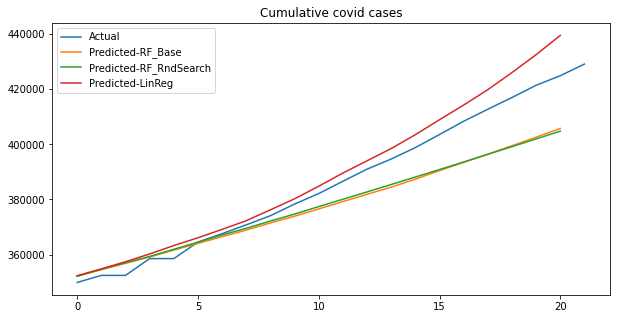

In [ ]:
A_onv=logconv(df2['logtot'][89],pred_cases)
A_onv1=logconv(df2['logtot'][89],pred_cases1)
B=[]
Alin=logconv(df2['logtot'][89],lin)
for i in range(len(df2['totcases'][89:])):
  B.append(df2.loc[89+i,'totcases'])
plt.subplots(figsize=(10,5))
plt.plot(B)
plt.plot(A_onv)
plt.plot(A_onv1)
plt.plot(Alin)
plt.title('Cumulative covid cases')
plt.legend(['Actual','Predicted-RF_Base','Predicted-RF_RndSearch','Predicted-LinReg'])

Difference in cumulative cases for Randomized Search on 21st April 2021: 174878
Difference in cumulative cases for Base Model on 21st April 2021: 279340


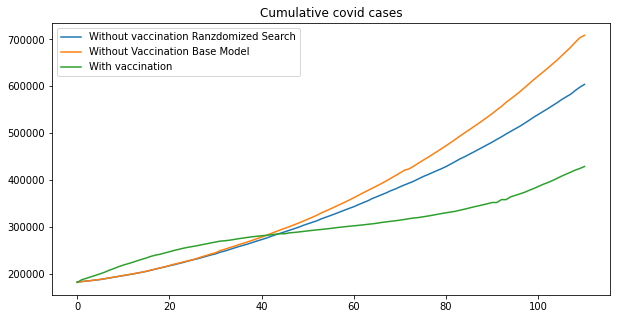

In [ ]:
#randomized search model
B_on=logconv(df1['logtot'][305],without_vacc)
#base model
B_on1=logconv(df1['logtot'][305],without_vacc1)
a=B_on[-1]
c=B_on1[-1]
b=df2.loc[110,'totcases']
plt.subplots(figsize=(10,5))
plt.plot(B_on)
plt.plot(B_on1)
plt.plot(df2['totcases'])
plt.legend(['Without vaccination Ranzdomized Search','Without Vaccination Base Model','With vaccination'])
plt.title('Cumulative covid cases')
print('Difference in cumulative cases for Randomized Search on 21st April 2021:',a-b)
print('Difference in cumulative cases for Base Model on 21st April 2021:',c-b)

Death/Case before vaccination  0.024870432185523542
Death/Case after vaccination 0.013196255324662703
Percentage reduction in Death/Case: 46.93998388840257
[[1.         0.57187926]
 [0.57187926 1.        ]]


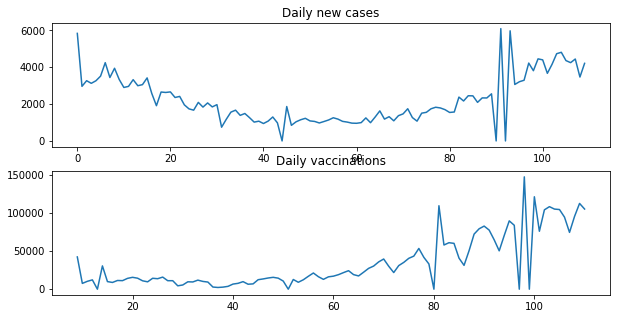

In [ ]:
compare(df1,df2)

**QUEBEC**

In [ ]:
df1=clean(fillnull(conv(pd.read_csv('../data_Final/quebec_data1.csv'))))
df2=clean(conv(pd.read_csv('../data_Final/quebec_vacc1.csv')))

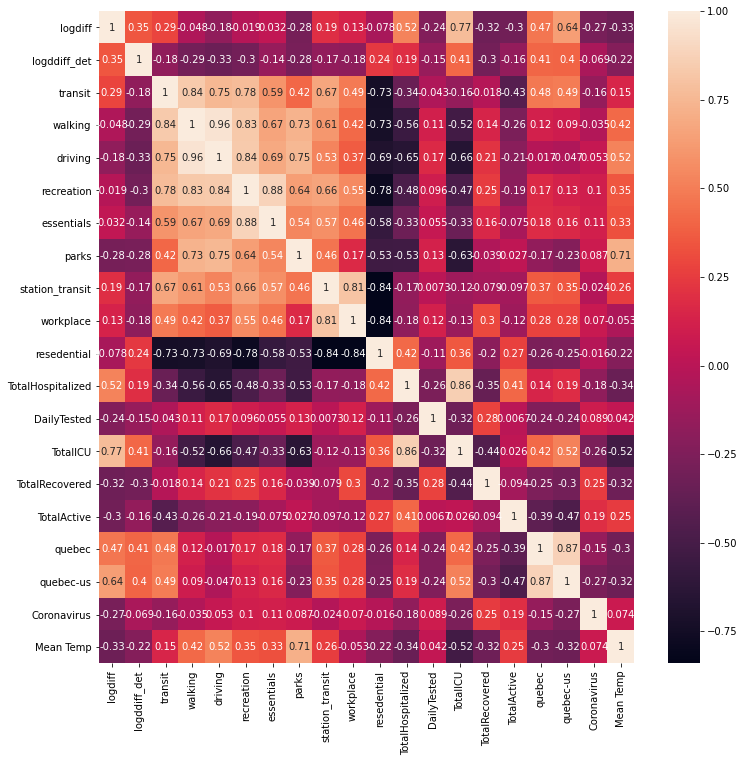

In [ ]:
corr_heatmap(df1)
#corr_heatmap(df2)

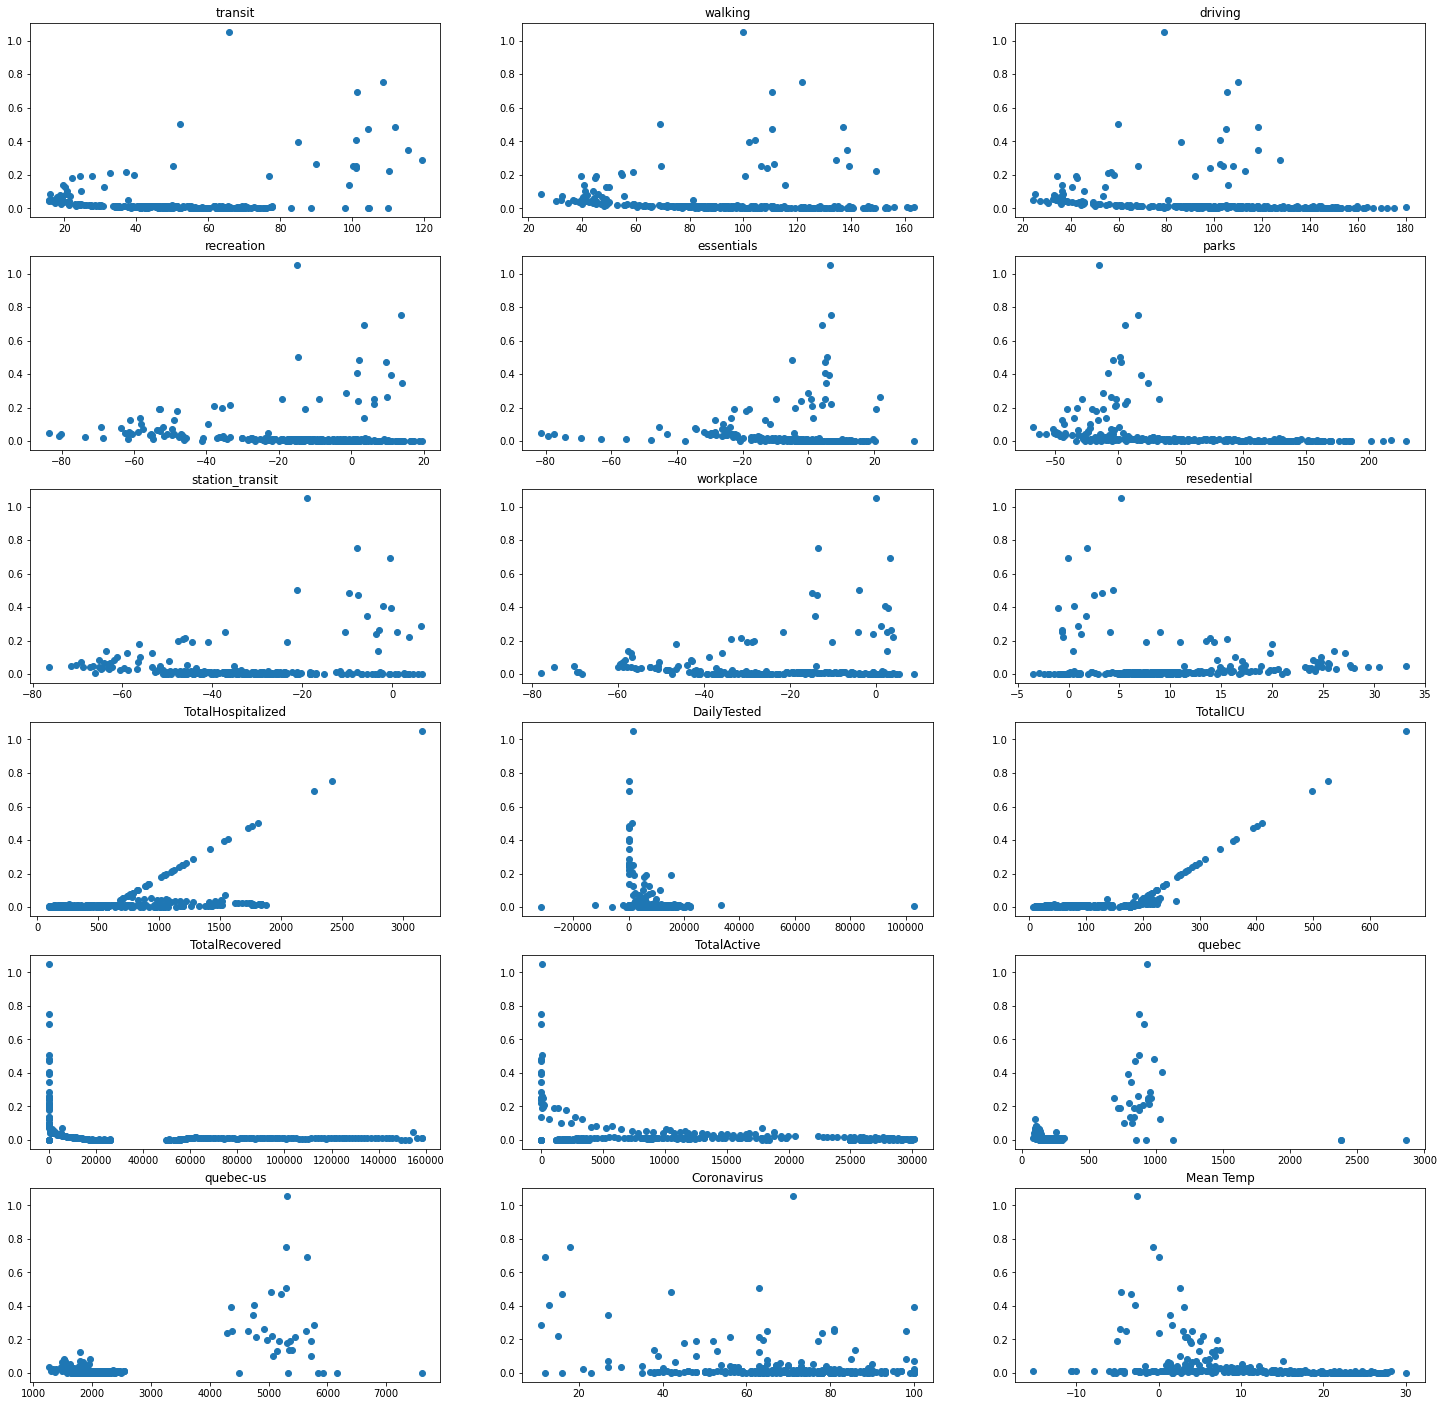

In [ ]:
scatter(df1)
#scatter(df2)

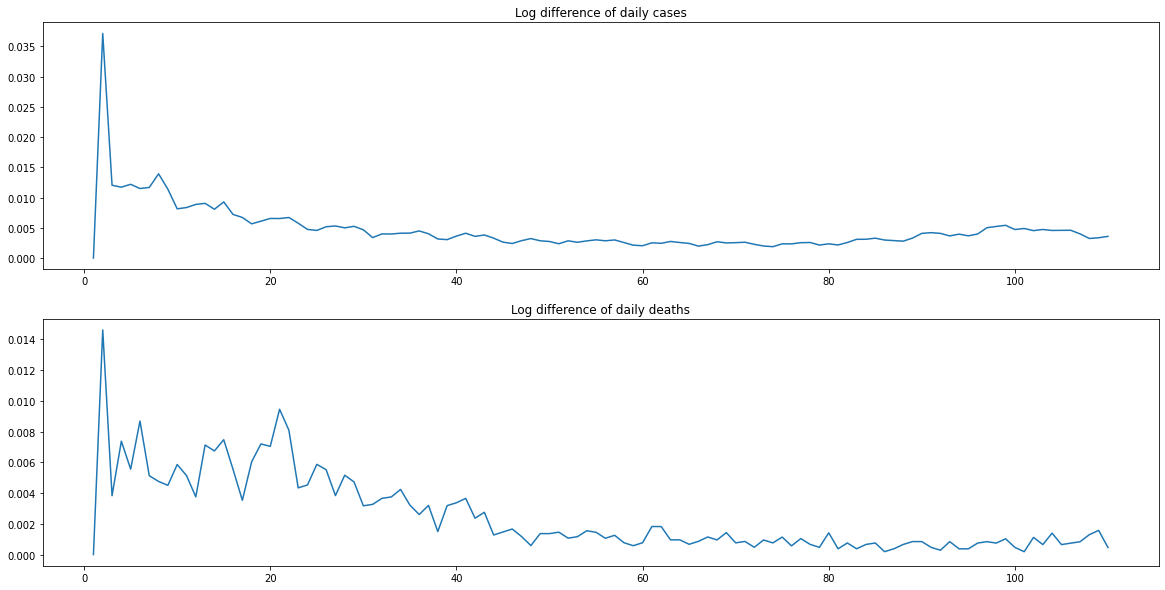

In [ ]:
#logd(df1)
logd(df2)

In [ ]:
#Modifying features
d=['TotalActive','TotalRecovered','Coronavirus']
for i in d:
  for j in range(len(df1)):
      if df1.loc[j,i]==0:
        df1.loc[j,i]=1/0.1
      else:
        df1.loc[j,i]=1/(df1.loc[j,i])

In [ ]:
x=hcorr(df1,0.4)

In [ ]:
x.corr()

,logdiff,TotalHospitalized,TotalICU,TotalRecovered,quebec,quebec-us,Coronavirus
logdiff,1.000000,0.519649,0.771227,0.657015,0.469481,0.635265,0.420282
TotalHospitalized,0.519649,1.000000,0.862041,0.307889,0.144324,0.185216,0.242855
TotalICU,0.771227,0.862041,1.000000,0.572703,0.423853,0.517840,0.379064
TotalRecovered,0.657015,0.307889,0.572703,1.000000,0.781599,0.803963,0.511078
quebec,0.469481,0.144324,0.423853,0.781599,1.000000,0.869206,0.281646
quebec-us,0.635265,0.185216,0.517840,0.803963,0.869206,1.000000,0.417890
Coronavirus,0.420282,0.242855,0.379064,0.511078,0.281646,0.417890,1.000000


In [ ]:
#Test train data for model quebec 
xtrain=x.drop(columns=['logdiff','quebec','quebec-us','TotalHospitalized'])[1:245];ytrain=df1['logdiff'][1:245]
xtest=x.drop(columns=['logdiff','quebec','quebec-us','TotalHospitalized'])[245:];ytest=df1['logdiff'][245:]

In [ ]:
lin=linreg(xtrain,ytrain,xtest,ytest)

MAE: 0.012912527032349894
MSE: 0.00034519452856731085
Rscore: -10.597206848472288


In [ ]:
B=df1[['TotalICU','TotalRecovered','Coronavirus']][195:306]

In [ ]:
#randomized search
predicted_cases,without_vacc=RandomForestSearchCV(xtrain,ytrain,xtest,ytest,B)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   41.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   50.9s finished


Model Performance
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=100, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1200, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)
MAE: 0.0025754590770779486
MSE: 3.3661650679534553e-05


In [ ]:
#base model
predicted_cases1,without_vacc1=RandomForestSearchCV2(xtrain,ytrain,xtest,ytest,B)

MAE: 0.0024763091240612802
MSE 3.2590923458284435e-05
Rscore -0.09492952364322238


Text(0.5, 1.0, 'Cumulative covid cases')

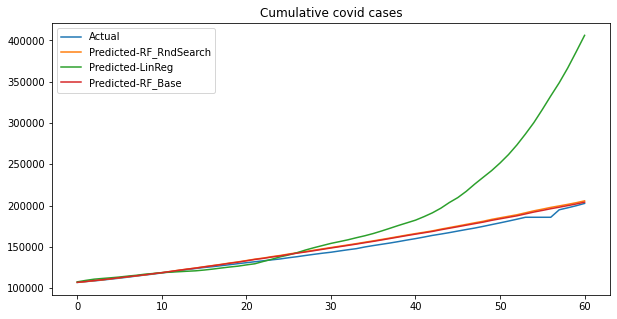

In [ ]:
A_qb=logconv(df1['logtot'][244],predicted_cases)
B=[]
Alin=logconv(df1['logtot'][244],lin)
A_RF=logconv(df1['logtot'][244],predicted_cases1)
for i in range(len(df1['totcases'][245:])):
  B.append(df1.loc[245+i,'totcases'])
plt.subplots(figsize=(10,5))
plt.plot(B)
plt.plot(A_qb)
plt.plot(Alin)
plt.plot(A_RF)

plt.legend(['Actual','Predicted-RF_RndSearch','Predicted-LinReg','Predicted-RF_Base'])
plt.title('Cumulative covid cases')

In [ ]:
#Modifying features
d=['TotalVaccinated']
for i in d:
  for j in range(len(df2)):
      if df2.loc[j,i]==0:
        df2.loc[j,i]=1/0.1
      else:
        df2.loc[j,i]=1/df2.loc[j,i]

In [ ]:
x=hcorr(df2,0.4)

In [ ]:
x.corr()

,logdiff,transit,walking,driving,TotalHospitalized,TotalRecovered,TotalActive,quebec,TotalVaccinated
logdiff,1.000000,-0.552368,-0.476648,-0.512174,0.419390,-0.598811,0.605404,0.414971,0.787305
transit,-0.552368,1.000000,0.873406,0.908869,-0.844208,0.894701,-0.794094,-0.141850,-0.688483
walking,-0.476648,0.873406,1.000000,0.912378,-0.664389,0.753368,-0.562163,-0.014060,-0.586113
driving,-0.512174,0.908869,0.912378,1.000000,-0.701576,0.742971,-0.635159,-0.074026,-0.613513
TotalHospitalized,0.419390,-0.844208,-0.664389,-0.701576,1.000000,-0.855012,0.893175,0.176920,0.645381
TotalRecovered,-0.598811,0.894701,0.753368,0.742971,-0.855012,1.000000,-0.866556,-0.278335,-0.804000
TotalActive,0.605404,-0.794094,-0.562163,-0.635159,0.893175,-0.866556,1.000000,0.409615,0.759673
quebec,0.414971,-0.141850,-0.014060,-0.074026,0.176920,-0.278335,0.409615,1.000000,0.231716
TotalVaccinated,0.787305,-0.688483,-0.586113,-0.613513,0.645381,-0.804000,0.759673,0.231716,1.000000


In [ ]:
#Test train data for model quebec vaccine
xtrain=x[['TotalVaccinated','walking','quebec']][9:90];ytrain=df2['logdiff'][9:90]
xtest=x[['TotalVaccinated','walking','quebec']][90:];ytest=df2['logdiff'][90:]

In [ ]:
lin=linreg(xtrain,ytrain,xtest,ytest)

MAE: 0.001444354999090745
MSE: 2.5662029390500557e-06
Rscore: -6.325921053131384


In [ ]:
#basemodel
pred_cases=RandomForestSearchCV1(xtrain,ytrain,xtest,ytest)

MAE: 0.0014851022432347896
MSE 2.5546383546179453e-06
Rscore -6.29290681592017


In [ ]:
#dummyB
B=np.zeros((3,3))

In [ ]:
#randomized search model
pred_cases1,flag=RandomForestSearchCV(xtrain,ytrain,xtest,ytest,B)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   47.2s finished


Model Performance
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=50, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=2000, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)
MAE: 0.0015159688082583005
MSE: 2.6452822202306706e-06


Text(0.5, 1.0, 'Cumulative covid cases')

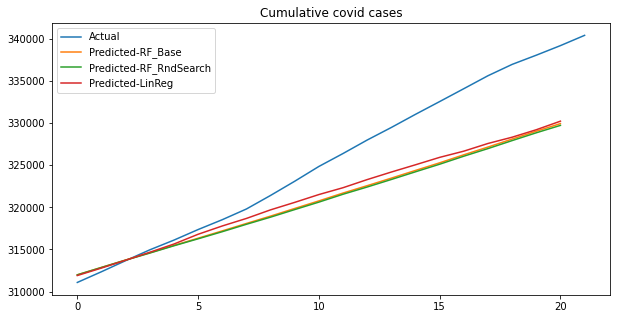

In [ ]:
A_qbv=logconv(df2['logtot'][89],pred_cases)
A_qbv1=logconv(df2['logtot'][89],pred_cases1)
B=[]
Alin=logconv(df2['logtot'][89],lin)
for i in range(len(df2['totcases'][89:])):
  B.append(df2.loc[89+i,'totcases'])
plt.subplots(figsize=(10,5))
plt.plot(B)
plt.plot(A_qbv)
plt.plot(A_qbv1)
plt.plot(Alin)
plt.legend(['Actual','Predicted-RF_Base','Predicted-RF_RndSearch','Predicted-LinReg'])
plt.title('Cumulative covid cases')

Difference in cumulative cases for Randomized Search on 21st April 2021: 303980
Difference in cumulative cases for Base Model on 21st April 2021: 301058


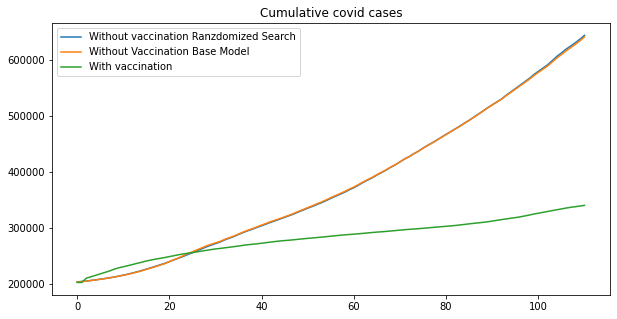

In [ ]:
#randomized search model
B_on=logconv(df1['logtot'][305],without_vacc)
#base model
B_on1=logconv(df1['logtot'][305],without_vacc1)
a=B_on[-1]
c=B_on1[-1]
b=df2.loc[110,'totcases']
plt.subplots(figsize=(10,5))
plt.plot(B_on)
plt.plot(B_on1)
plt.plot(df2['totcases'])
plt.legend(['Without vaccination Ranzdomized Search','Without Vaccination Base Model','With vaccination'])
plt.title('Cumulative covid cases')
print('Difference in cumulative cases for Randomized Search on 21st April 2021:',a-b)
print('Difference in cumulative cases for Base Model on 21st April 2021:',c-b)

Death/Case before vaccination  0.04059415712593762
Death/Case after vaccination 0.018961061587154097
Percentage reduction in Death/Case: 53.29115584705925
[[1.         0.18980577]
 [0.18980577 1.        ]]


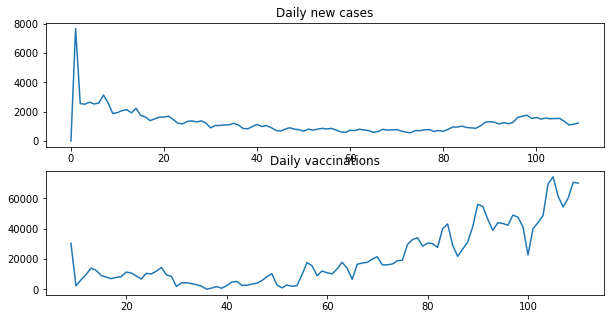

In [ ]:
compare(df1,df2)

**ALBERTA**

In [ ]:
df1=clean(fillnull(conv(pd.read_csv('../data_Final/alberta_data1.csv'))))
df2=clean(conv(pd.read_csv('../data_Final/alberta_vacc1.csv')))

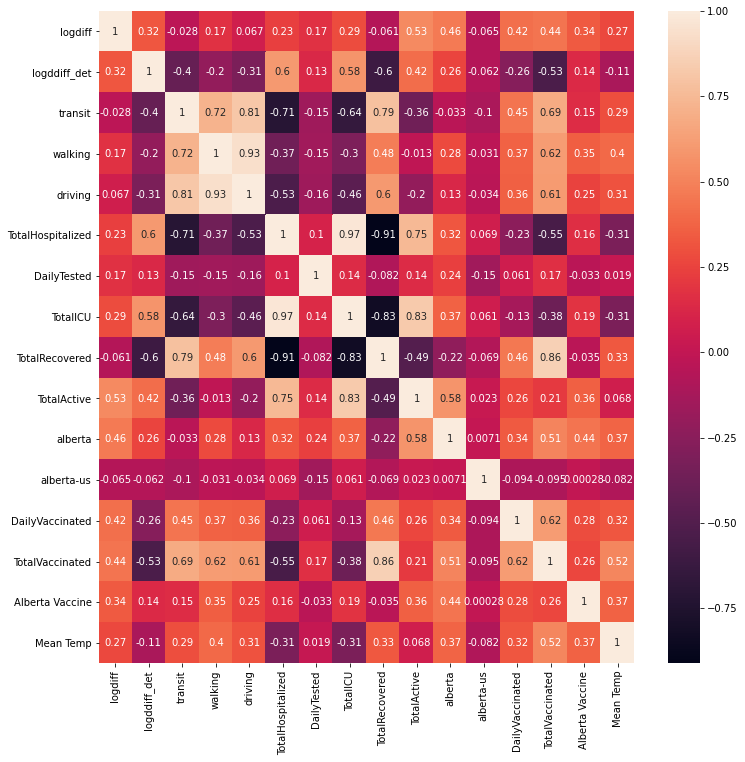

In [ ]:
#corr_heatmap(df1)
corr_heatmap(df2)

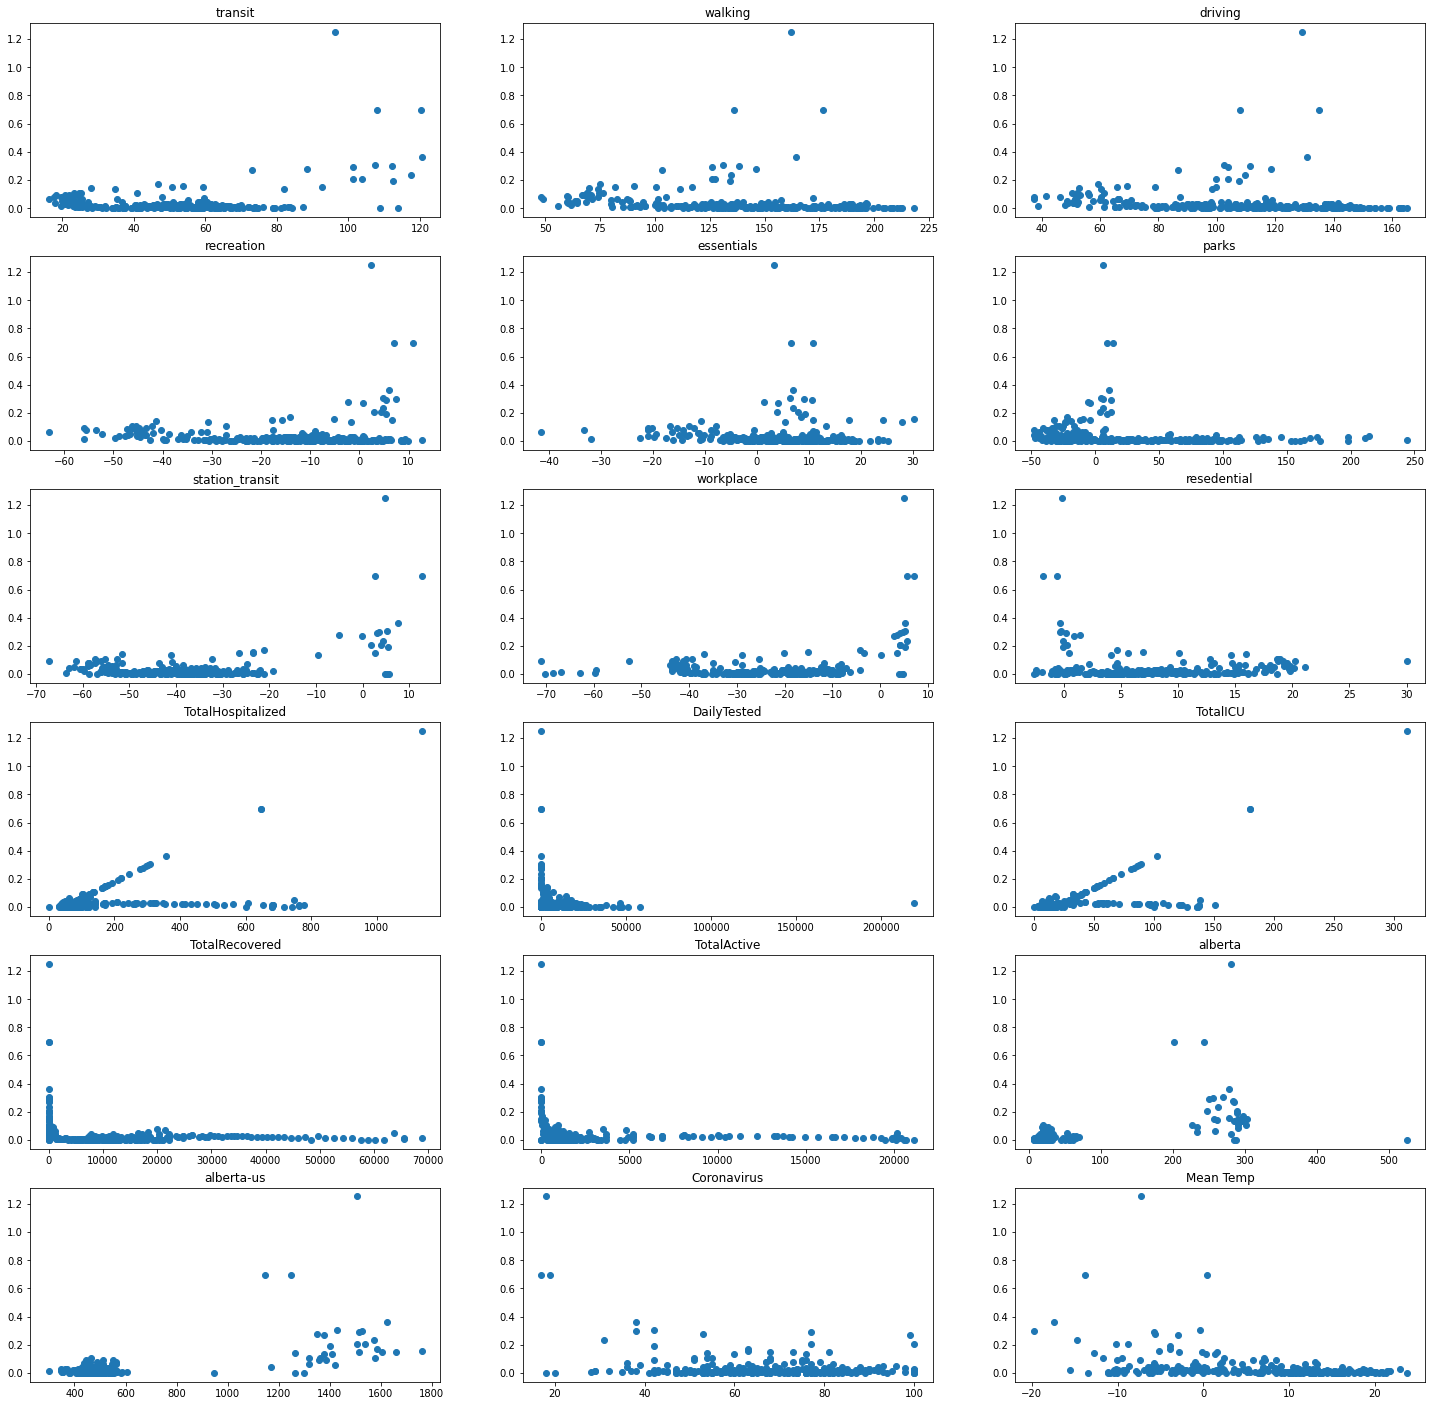

In [ ]:
scatter(df1)
#scatter(df2)

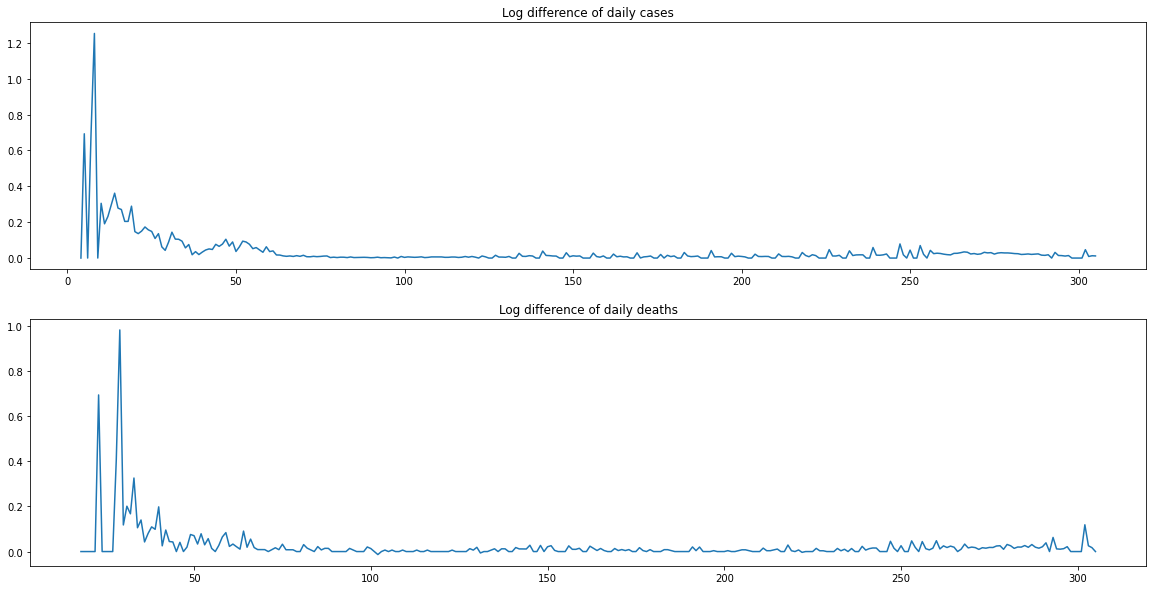

In [ ]:
logd(df1)

In [ ]:
d=['TotalRecovered','TotalActive','Coronavirus']
for i in d:
  for j in range(len(df1)):
      if df1.loc[j,i]==0:
        df1.loc[j,i]=1/0.1
      else:
        df1.loc[j,i]=1/(df1.loc[j,i])

In [ ]:
x=hcorr(df1,0.4)

In [ ]:
x.corr()

,logdiff,station_transit,TotalHospitalized,TotalICU,TotalRecovered,TotalActive,alberta,alberta-us,Coronavirus
logdiff,1.000000,0.482353,0.441080,0.635180,0.635837,0.639582,0.561308,0.612568,0.535125
station_transit,0.482353,1.000000,0.103297,0.196150,0.721193,0.683501,0.610796,0.563030,0.281616
TotalHospitalized,0.441080,0.103297,1.000000,0.962306,0.211851,0.251487,0.278692,0.180272,0.266708
TotalICU,0.635180,0.196150,0.962306,1.000000,0.380086,0.388140,0.427029,0.360103,0.362308
TotalRecovered,0.635837,0.721193,0.211851,0.380086,1.000000,0.724125,0.880680,0.876379,0.332135
TotalActive,0.639582,0.683501,0.251487,0.388140,0.724125,1.000000,0.710094,0.547108,0.502096
alberta,0.561308,0.610796,0.278692,0.427029,0.880680,0.710094,1.000000,0.849005,0.257602
alberta-us,0.612568,0.563030,0.180272,0.360103,0.876379,0.547108,0.849005,1.000000,0.318375
Coronavirus,0.535125,0.281616,0.266708,0.362308,0.332135,0.502096,0.257602,0.318375,1.000000


In [ ]:
#Test train data for model alberta
xtrain=x.drop(columns=['logdiff','station_transit','TotalHospitalized','TotalActive','alberta','alberta-us','TotalICU'])[5:245];ytrain=df1['logdiff'][5:245]
xtest=x.drop(columns=['logdiff','station_transit','TotalHospitalized','TotalActive','alberta','alberta-us','TotalICU'])[245:];ytest=df1['logdiff'][245:]

In [ ]:
lin=linreg(xtrain,ytrain,xtest,ytest)

MAE: 0.01956789412526039
MSE: 0.0005823120878165411
Rscore: -1.5136430909564758


In [ ]:
B=df1[['TotalRecovered','Coronavirus']][195:306]

In [ ]:
#randomized search model
predicted_cases,without_vacc=RandomForestSearchCV(xtrain,ytrain,xtest,ytest,B)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   40.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   50.2s finished


Model Performance
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=100, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1200, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)
MAE: 0.011067778909327938
MSE: 0.00024163076442523817


In [ ]:
#base model
predicted_cases1,without_vacc1=RandomForestSearchCV2(xtrain,ytrain,xtest,ytest,B)

MAE: 0.014090245103278687
MSE 0.0003524772325261248
Rscore -0.5215242458402989


Text(0.5, 1.0, 'Cumulative covid cases')

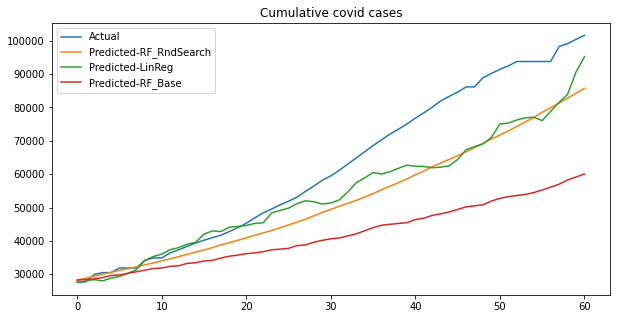

In [ ]:
#Randomized search RF
A_ab=logconv(10.227887207923073,predicted_cases)
B=[]
#base RF
A_ab1=logconv(10.227887207923073,predicted_cases1)
Alin=logconv(10.227887207923073,lin)
for i in range(len(df1['totcases'][245:])):
  B.append(df1.loc[245+i,'totcases'])
plt.subplots(figsize=(10,5))
plt.plot(B)
plt.plot(A_ab)
plt.plot(Alin)
plt.plot(A_ab1)
plt.legend(['Actual','Predicted-RF_RndSearch','Predicted-LinReg','Predicted-RF_Base'])
plt.title('Cumulative covid cases')

In [ ]:
d=['TotalRecovered','Alberta Vaccine']
for i in d:
  for j in range(len(df2)):
    if i=='TotalRecovered':
      if df2.loc[j,i]==0:
        df2.loc[j,i]=1/0.1
      else:
        df2.loc[j,i]=1/(df2.loc[j,i]**2)
    elif i=='Alberta Vaccine':
      if df2.loc[j,i]==0:
        df2.loc[j,i]=0
      else:
        df2.loc[j,i]=np.log(df2.loc[j,i])

In [ ]:
x=hcorr(df2,0.4)

In [ ]:
x.corr()

,logdiff,TotalActive,alberta,DailyVaccinated,TotalVaccinated
logdiff,1.000000,0.530408,0.463311,0.421440,0.444490
TotalActive,0.530408,1.000000,0.600535,0.262948,0.214644
alberta,0.463311,0.600535,1.000000,0.339227,0.510368
DailyVaccinated,0.421440,0.262948,0.339227,1.000000,0.617638
TotalVaccinated,0.444490,0.214644,0.510368,0.617638,1.000000


In [ ]:
#Test train data for model alberta
xtrain=x[['TotalVaccinated','TotalActive']][9:90];ytrain=df2['logdiff'][9:90]
xtest=x[['TotalVaccinated','TotalActive']][90:];ytest=df2['logdiff'][90:]

In [ ]:
lin=linreg(xtrain,ytrain,xtest,ytest)

MAE: 0.0038699178127267917
MSE: 3.481986485184669e-05
Rscore: -0.042181103390702246


In [ ]:
#base model
pred_cases=RandomForestSearchCV1(xtrain,ytrain,xtest,ytest)

MAE: 0.004656282828702952
MSE 4.0383430404397306e-05
Rscore -0.2087022231886784


In [ ]:
#dummy B
B=np.zeros((2,2))

In [ ]:
#randomized search model
pred_cases1,flag=RandomForestSearchCV(xtrain,ytrain,xtest,ytest,B)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   46.3s finished


Model Performance
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=100, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1200, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)
MAE: 0.004907033028919095
MSE: 4.259267169361823e-05


Text(0.5, 1.0, 'Cumulative covid cases')

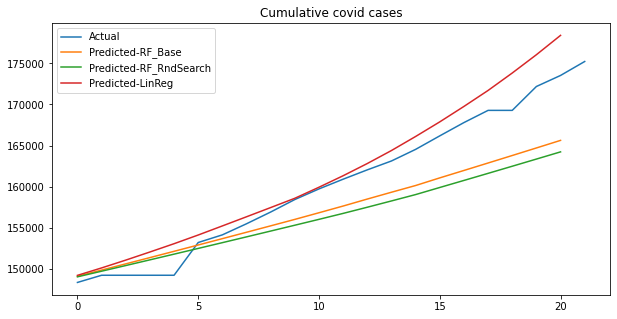

In [ ]:
#base
A_abv=logconv(df2['logtot'][89],pred_cases)
#randomized search
A_abv1=logconv(df2['logtot'][89],pred_cases1)
B=[]
Alin=logconv(df2['logtot'][89],lin)
for i in range(len(df2['totcases'][89:])):
  B.append(df2.loc[89+i,'totcases'])
plt.subplots(figsize=(10,5))
plt.plot(B)
plt.plot(A_abv)
plt.plot(A_abv1)
plt.plot(Alin)

plt.legend(['Actual','Predicted-RF_Base','Predicted-RF_RndSearch','Predicted-LinReg'])
plt.title('Cumulative covid cases')

In [ ]:
df1['logtot'][305]

'11.52907437'

Difference in cumulative cases for Randomized Search on 21st April 2021: 395193
Difference in cumulative cases for Base Model on 21st April 2021: 234738


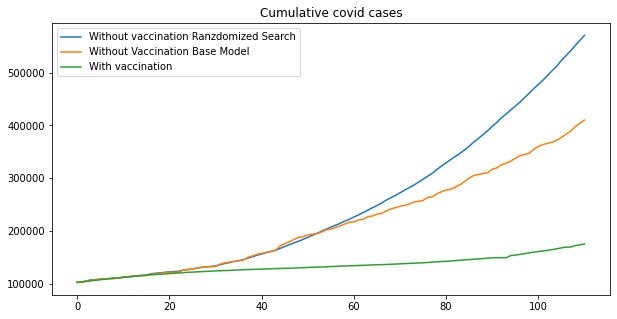

In [ ]:
#randomized search model
B_on=logconv(11.52907437,without_vacc)
#base model
B_on1=logconv(11.52907437,without_vacc1)
a=B_on[-1]
c=B_on1[-1]
b=df2.loc[110,'totcases']
plt.subplots(figsize=(10,5))
plt.plot(B_on)
plt.plot(B_on1)
plt.plot(df2['totcases'])
plt.legend(['Without vaccination Ranzdomized Search','Without Vaccination Base Model','With vaccination'])
plt.title('Cumulative covid cases')
print('Difference in cumulative cases for Randomized Search on 21st April 2021:',a-b)
print('Difference in cumulative cases for Base Model on 21st April 2021:',c-b)

Death/Case before vaccination  0.010292439091588931
Death/Case after vaccination 0.013858537799784238
Percentage reduction in Death/Case: -34.64775138780809
[[1.         0.51233228]
 [0.51233228 1.        ]]


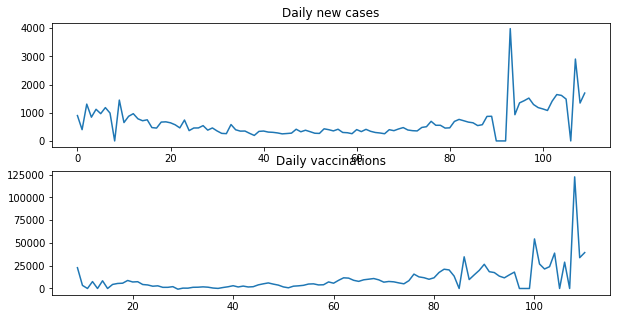

In [ ]:
compare(df1,df2)

**BRITISH** **COLUMBIA**

In [ ]:
df1=clean(fillnull(conv(pd.read_csv('../data_Final/britishcolumbia_data1.csv'))))
df2=clean(conv(pd.read_csv('../data_Final/britishcolumbia_vacc1.csv')))

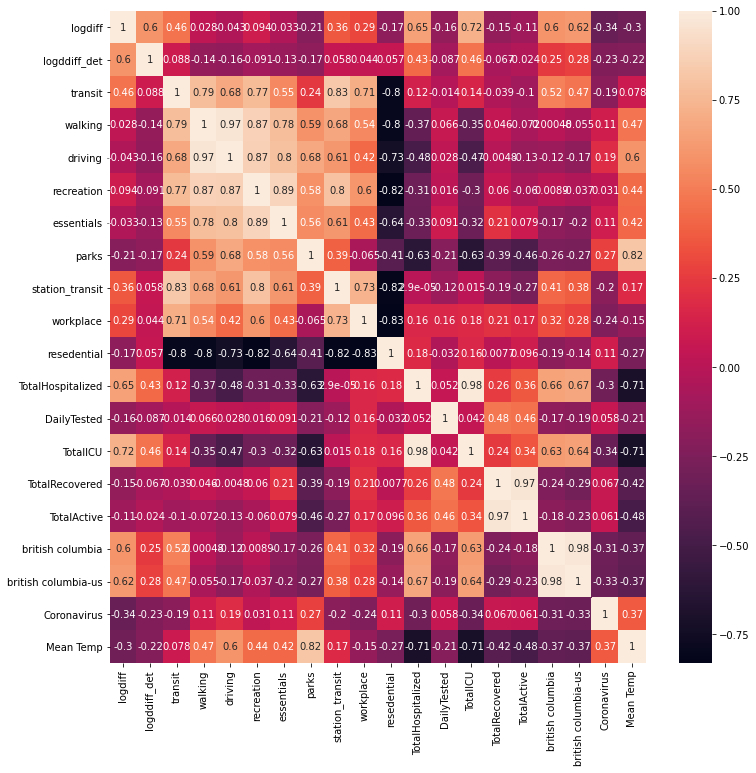

In [ ]:
corr_heatmap(df1)
#corr_heatmap(df2)

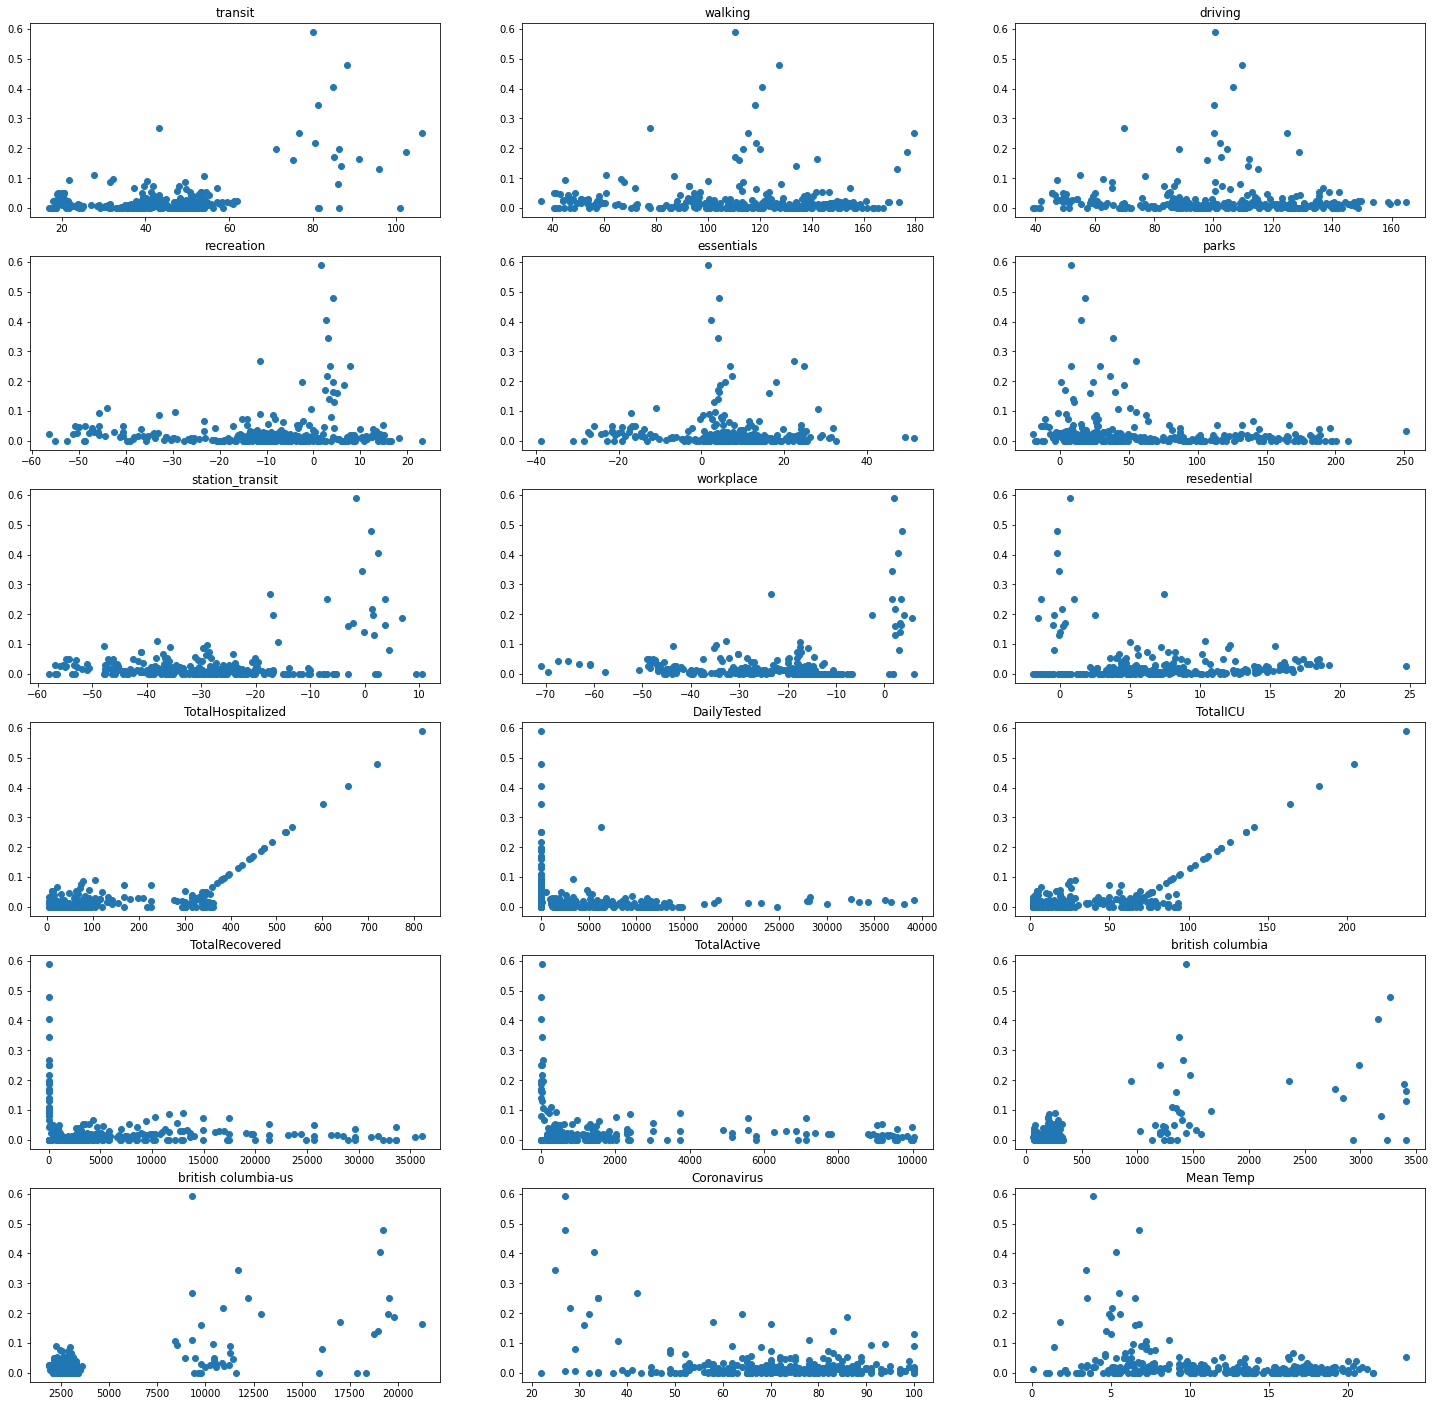

In [ ]:
scatter(df1)
#scatter(df2)

In [ ]:
d=['TotalActive','TotalRecovered','DailyTested']
for i in d:
  for j in range(len(df1)):
       if df1.loc[j,i]==0:
         df1.loc[j,i]=1/0.1
       else:
         df1.loc[j,i]=1/df1.loc[j,i]

In [ ]:
x=hcorr(df1,0.4)

In [ ]:
x.corr()

,logdiff,transit,TotalHospitalized,TotalICU,TotalRecovered,TotalActive,british columbia,british columbia-us
logdiff,1.000000,0.458466,0.654676,0.721923,0.547449,0.499268,0.598146,0.615914
transit,0.458466,1.000000,0.124741,0.142112,0.495850,0.600011,0.525671,0.476916
TotalHospitalized,0.654676,0.124741,1.000000,0.979981,0.515460,0.433434,0.657289,0.671202
TotalICU,0.721923,0.142112,0.979981,1.000000,0.515543,0.439142,0.631488,0.642586
TotalRecovered,0.547449,0.495850,0.515460,0.515543,1.000000,0.659620,0.785770,0.724235
TotalActive,0.499268,0.600011,0.433434,0.439142,0.659620,1.000000,0.810593,0.773578
british columbia,0.598146,0.525671,0.657289,0.631488,0.785770,0.810593,1.000000,0.973187
british columbia-us,0.615914,0.476916,0.671202,0.642586,0.724235,0.773578,0.973187,1.000000


In [ ]:
#Test train data for BC
xtrain=x[['transit','TotalHospitalized']][1:245];ytrain=df1['logdiff'][1:245]
xtest=x[['transit','TotalHospitalized']][245:];ytest=df1['logdiff'][245:]

In [ ]:
lin=linreg(xtrain,ytrain,xtest,ytest)

MAE: 0.05234602360827308
MSE: 0.0038737953599077613
Rscore: -6.412642053110023


In [ ]:
B=df1[['transit','TotalHospitalized']][195:306]

In [ ]:
#randomized searchmmodel
predicted_cases,without_vacc=RandomForestSearchCV(xtrain,ytrain,xtest,ytest,B)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   50.4s finished


Model Performance
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=100, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1200, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)
MAE: 0.028338689771077848
MSE: 0.0012924649124571525


In [ ]:
#base model
predicted_cases1,without_vacc1=RandomForestSearchCV2(xtrain,ytrain,xtest,ytest,B)

MAE: 0.02670392608978142
MSE 0.0011148439096847643
Rscore -1.133292567054871


Text(0.5, 1.0, 'Cumulative covid cases')

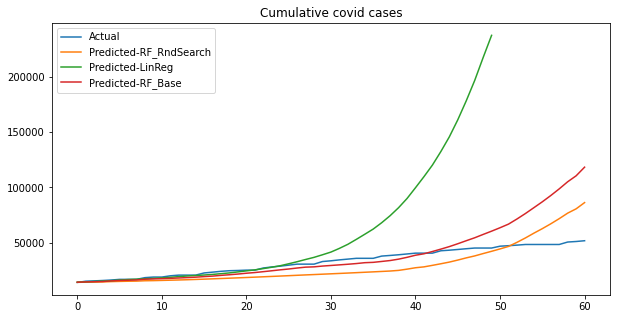

In [ ]:
#Randomized search RF
A_ab=logconv(df1['logtot'][244],predicted_cases)
B=[]
#base RF
A_ab1=logconv(df1['logtot'][244],predicted_cases1)
Alin=logconv(df1['logtot'][244],lin)

for i in range(len(df1['totcases'][245:])):
  B.append(df1.loc[245+i,'totcases'])
plt.subplots(figsize=(10,5))
plt.plot(B)
plt.plot(A_ab)
plt.plot(Alin[:50])

plt.plot(A_ab1)
plt.legend(['Actual','Predicted-RF_RndSearch','Predicted-LinReg','Predicted-RF_Base'])
plt.title('Cumulative covid cases')

In [ ]:
d=['DailyVaccinated','Coronavirus','DailyTested']
for i in d:
  for j in range(len(df2)):
      if df2.loc[j,i]==0:
        df2.loc[j,i]=0
      else:
        df2.loc[j,i]=np.log(df2.loc[j,i])

In [ ]:
x=hcorr(df2,0.3)

In [ ]:
x.corr()

,logdiff,walking,driving,DailyTested,DailyVaccinated,Coronavirus
logdiff,1.000000,-0.326843,-0.313372,0.418157,0.556862,0.341381
walking,-0.326843,1.000000,0.930765,-0.297669,-0.497189,-0.036697
driving,-0.313372,0.930765,1.000000,-0.194628,-0.379088,-0.076874
DailyTested,0.418157,-0.297669,-0.194628,1.000000,0.858576,0.248689
DailyVaccinated,0.556862,-0.497189,-0.379088,0.858576,1.000000,0.273367
Coronavirus,0.341381,-0.036697,-0.076874,0.248689,0.273367,1.000000


In [ ]:
#Test train data for model bc vaccine
xtrain=x[['DailyVaccinated','Coronavirus']][10:90];ytrain=df2['logdiff'][10:90]
xtest=x[['DailyVaccinated','Coronavirus']][90:];ytest=df2['logdiff'][90:]

In [ ]:
lin=linreg(xtrain,ytrain,xtest,ytest)

MAE: 0.005891104912035994
MSE: 6.411231646161023e-05
Rscore: 0.047456477671834474


In [ ]:
#base model
pred_cases=RandomForestSearchCV1(xtrain,ytrain,xtest,ytest)

MAE: 0.008039318064896824
MSE 9.855947906712274e-05
Rscore -0.46433943633345165


In [ ]:
#dummy B
B=np.zeros((2,2))

In [ ]:
#randomized search model
pred_cases1,flag=RandomForestSearchCV(xtrain,ytrain,xtest,ytest,B)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   47.0s finished


Model Performance
RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=70, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=1200, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)
MAE: 0.007246043684432591
MSE: 7.576485512651097e-05


Text(0.5, 1.0, 'Cumulative covid cases')

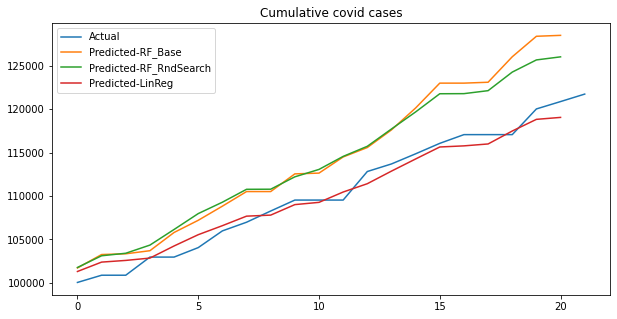

In [ ]:
#base model
A_bcv=logconv(df2['logtot'][89],pred_cases)
#randomized search model
A_bcv1=logconv(df2['logtot'][89],pred_cases1)
B=[]
Alin=logconv(df2['logtot'][89],lin)
for i in range(len(df2['totcases'][89:])):
  B.append(df2.loc[89+i,'totcases'])
plt.subplots(figsize=(10,5))
plt.plot(B)
plt.plot(A_bcv)
plt.plot(A_bcv1)
plt.plot(Alin)
plt.legend(['Actual','Predicted-RF_Base','Predicted-RF_RndSearch','Predicted-LinReg'])
plt.title('Cumulative covid cases')

Difference in cumulative cases for Randomized Search on 21st April 2021: 513550
Difference in cumulative cases for Base Model on 21st April 2021: 772585


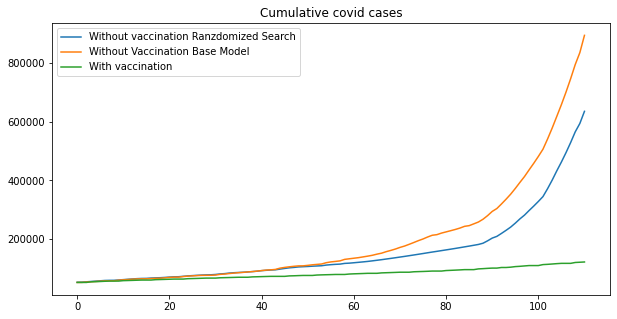

In [ ]:
#randomized search model
B_on=logconv(df1['logtot'][305],without_vacc)
#base model
B_on1=logconv(df1['logtot'][305],without_vacc1)
a=B_on[-1]
c=B_on1[-1]
b=df2.loc[110,'totcases']
plt.subplots(figsize=(10,5))
plt.plot(B_on)
plt.plot(B_on1)
plt.plot(df2['totcases'])
plt.legend(['Without vaccination Ranzdomized Search','Without Vaccination Base Model','With vaccination'])
plt.title('Cumulative covid cases')
print('Difference in cumulative cases for Randomized Search on 21st April 2021:',a-b)
print('Difference in cumulative cases for Base Model on 21st April 2021:',c-b)

Death/Case before vaccination  0.017332922934862067
Death/Case after vaccination 0.009245853700491679
Percentage reduction in Death/Case: 46.65727335638641
[[1.         0.53181049]
 [0.53181049 1.        ]]


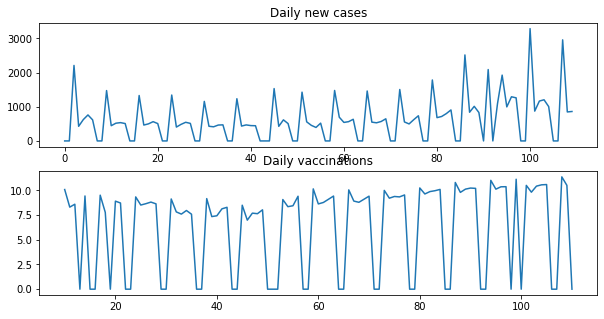

In [ ]:
compare(df1,df2)